In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [3]:
data = pd.read_csv("/home/oskar/Desktop/fagprojekt/compas/compas-scores-raw.csv")
# Til at se på dataen 
#print(data.head)
#print(data.columns)

# Check if there are any missing values
print(np.count_nonzero(data["IsDeleted"] == 1))

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


0
No GPU available.


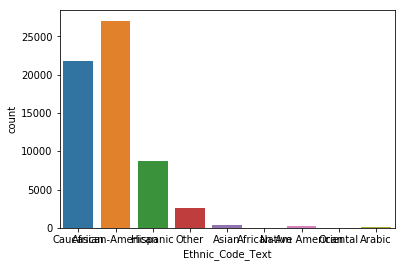

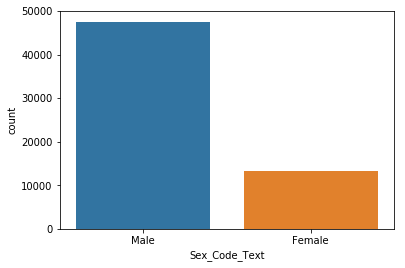

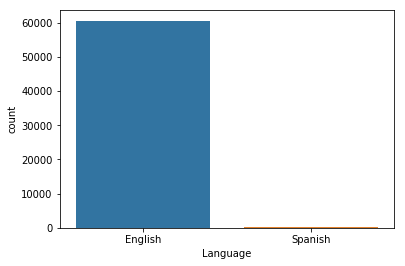

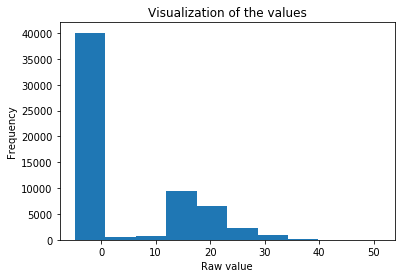

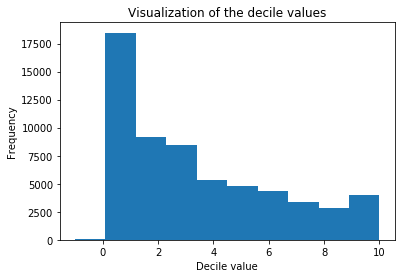

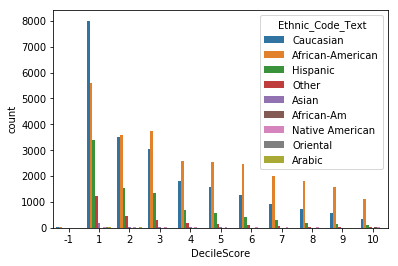

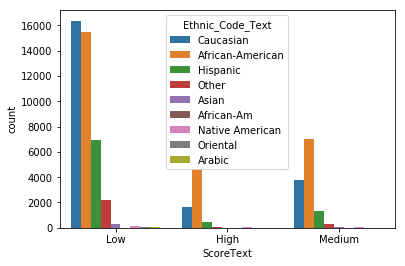

In [4]:
def plots():
    # Show distribution of different ethnicities and sexes
    sb.countplot(x = "Ethnic_Code_Text", data = data)
    plt.show()
    sb.countplot(x = "Sex_Code_Text", data = data)
    plt.show()
    sb.countplot(x = "Language", data = data)
    plt.show()
    
    # Showing the distribution of the raw and decile values
    plt.xlabel("Raw value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the values")
    plt.hist(data["RawScore"])
    plt.show()
    
    plt.xlabel("Decile value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the decile values")
    plt.hist(data["DecileScore"])
    plt.show()
    
    
    #sb.countplot(x = "RawScore", hue = "Ethnic_Code_Text", data = data)
    #plt.show()
    
    # Indication that some black people might get higher sentences that white people
    sb.countplot(x = "DecileScore", hue = "Ethnic_Code_Text", data = data)
    plt.show()
    
    sb.countplot(x = "ScoreText", hue = "Ethnic_Code_Text", data = data)
    plt.show()
plots()

### DATA PRE-PROCESSING AND PREPARATION ###

In [5]:
categoricals = ["Agency_Text", "Sex_Code_Text", "Ethnic_Code_Text", "ScaleSet_ID", "AssessmentReason", "Language", "LegalStatus", "CustodyStatus", "MaritalStatus", "RecSupervisionLevel"]

# Changing date of birth into age, as this should work better in a neural network
ages = [None] * len(data["DateOfBirth"])
for i in range(len(data["DateOfBirth"])):
    ages[i] = 20 +(100 - int(data["DateOfBirth"][i].split("/")[2]))
data["DateOfBirth"] = ages
numericals = ["DateOfBirth"]

outputs = ["DecileScore"]
data["DecileScore"] = data["DecileScore"].replace(-1, 0)
data["DecileScore"] = data["DecileScore"].astype("category")
print(data["DecileScore"].cat.categories)

for category in categoricals:
    data[category] = data[category].astype("category")

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')


In [6]:

# Preparing data for pytorch
Xcat = []
for i in range(len(categoricals)):
    Xcat.append(data[categoricals[i]].cat.codes.values)
Xcat = torch.tensor(Xcat , dtype = torch.int64).T

#Converting the numerical values to a tensor
Xnum = np.stack([data[col].values for col in numericals], 1)
Xnum = torch.tensor(Xnum, dtype=torch.float)

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]

In [7]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [8]:
# Define and show the model
model = Model(categorical_embedding_sizes, 1, 11, [10,10], p=0.4)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(9, 5)
    (3): Embedding(2, 1)
    (4): Embedding(1, 1)
    (5): Embedding(2, 1)
    (6): Embedding(7, 4)
    (7): Embedding(6, 3)
    (8): Embedding(7, 4)
    (9): Embedding(4, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=10, out_features=11, bias=True)
  )
)


In [9]:
# Loss function and optimization
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 1e-6)

epoch:   1 loss: 2.72879982
epoch:  26 loss: 2.56777406
epoch:  51 loss: 2.45612240
epoch:  76 loss: 2.35196853
epoch: 101 loss: 2.27064753
epoch: 126 loss: 2.20194793
epoch: 151 loss: 2.15152836
epoch: 176 loss: 2.11167860
epoch: 201 loss: 2.08336377
epoch: 226 loss: 2.06244731
epoch: 251 loss: 2.03597999
epoch: 276 loss: 2.01827979
epoch: 301 loss: 2.00028610
epoch: 326 loss: 1.98196316
epoch: 351 loss: 1.96911502
epoch: 376 loss: 1.95832479
epoch: 401 loss: 1.94349802
epoch: 426 loss: 1.93123925
epoch: 451 loss: 1.92597604
epoch: 476 loss: 1.91599500
epoch: 501 loss: 1.91742146
epoch: 526 loss: 1.90709221
epoch: 551 loss: 1.90470815
epoch: 576 loss: 1.90138662
epoch: 601 loss: 1.89527607
epoch: 626 loss: 1.88858759
epoch: 651 loss: 1.88777733
epoch: 676 loss: 1.88634539
epoch: 701 loss: 1.87896979
epoch: 726 loss: 1.87875593
epoch: 751 loss: 1.87636960
epoch: 776 loss: 1.87354040
epoch: 801 loss: 1.87249529
epoch: 826 loss: 1.87161434
epoch: 851 loss: 1.86593831
epoch: 876 loss: 1.8

/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


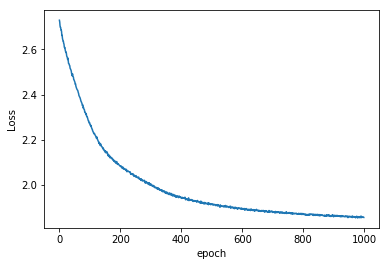

In [10]:
epochs = 1000
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest)


y_val = np.argmax(y_val, axis=1)


print(confusion_matrix(ytest,y_val))
print(classification_report(ytest,y_val))
print(accuracy_score(ytest, y_val))